In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import accuracy_score
from scipy.stats import entropy
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import MinMaxScaler

In [110]:
df =pd.read_csv('banana  (with class label).csv')
df_noclass=df.drop(['class'],axis=1)
print(df_noclass)
df_noclass

          x      y
0     0.228  0.559
1     0.216  0.528
2     0.221  0.552
3     0.215  0.538
4     0.224  0.548
...     ...    ...
4806  0.507  0.269
4807  0.526  0.237
4808  0.513  0.233
4809  0.506  0.221
4810  0.515  0.260

[4811 rows x 2 columns]


,x,y
0,0.228,0.559
1,0.216,0.528
2,0.221,0.552
3,0.215,0.538
4,0.224,0.548
...,...,...
4806,0.507,0.269
4807,0.526,0.237
4808,0.513,0.233
4809,0.506,0.221


偏度(Skewness): 0.24, 峰度(Kurtosis): -1.1


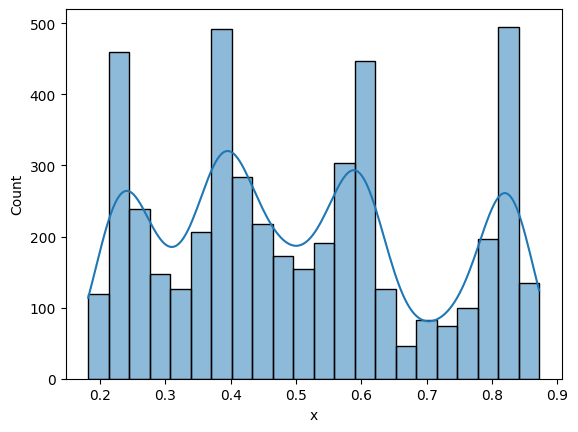

偏度(Skewness): -0.32, 峰度(Kurtosis): -1.07


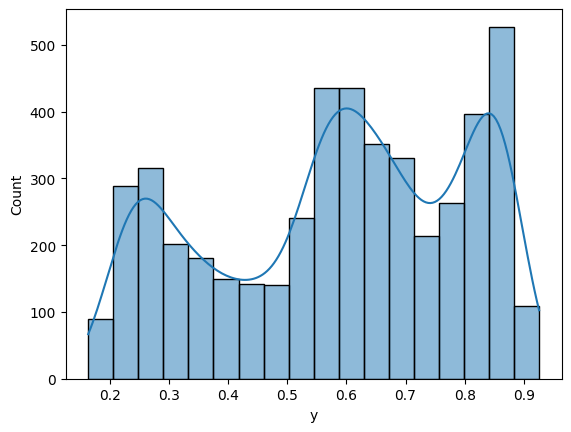

In [111]:
# skewness 與 kurtosis
skewness = round(df_noclass['x'].skew(), 2)
kurtosis = round(df_noclass['x'].kurt(), 2)
print(f"偏度(Skewness): {skewness}, 峰度(Kurtosis): {kurtosis}")

# 繪製分布圖
sns.histplot(df_noclass['x'], kde=True)
plt.show()

skewness = round(df_noclass['y'].skew(), 2)
kurtosis = round(df_noclass['y'].kurt(), 2)
print(f"偏度(Skewness): {skewness}, 峰度(Kurtosis): {kurtosis}")

# 繪製分布圖
sns.histplot(df_noclass['y'], kde=True)
plt.show()

In [112]:
# scaler=MinMaxScaler()
# df_noclass['x']=scaler.fit_transform(df_noclass[['x']])
# df_noclass['y']=scaler.fit_transform(df_noclass[['y']])

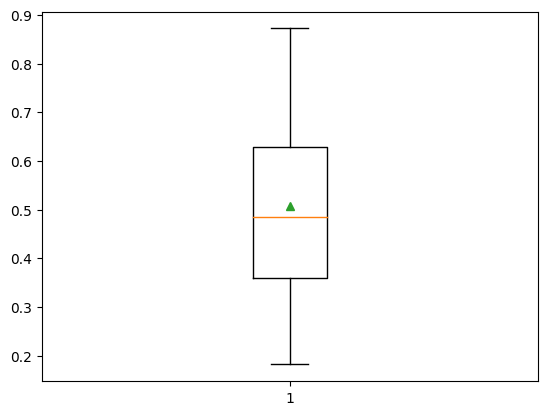

Shape Of The Before Ouliers:  (4811,)
Shape Of The After Ouliers:  (4811,)


In [113]:
#箱型圖(用IQR)
plt.boxplot(df['x'], showmeans=True)
plt.show()

# 將所有特徵超出1.5倍IQR的概念將這些Outlier先去掉，避免對Model造成影響。
print ("Shape Of The Before Ouliers: ",df['x'].shape)
n=1.5
#IQR = Q3-Q1
IQR = np.percentile(df['x'],75) - np.percentile(df['x'],25)
# outlier = Q3 + n*IQR 
transform_data=df[df['x'] < np.percentile(df['x'],75)+n*IQR]
# outlier = Q1 - n*IQR 
transform_data=transform_data[transform_data['x'] > np.percentile(transform_data['x'],25)-n*IQR]['x']
print ("Shape Of The After Ouliers: ",transform_data.shape)

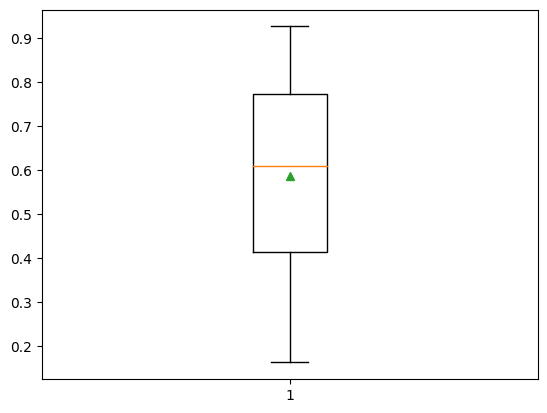

Shape Of The Before Ouliers:  (4811,)
Shape Of The After Ouliers:  (4811,)


In [114]:
#箱型圖(用IQR)
plt.boxplot(df['y'], showmeans=True)
plt.show()

# 將所有特徵超出1.5倍IQR的概念將這些Outlier先去掉，避免對Model造成影響。
print ("Shape Of The Before Ouliers: ",df['y'].shape)
n=1.5
#IQR = Q3-Q1
IQR = np.percentile(df['y'],75) - np.percentile(df['y'],25)
# outlier = Q3 + n*IQR 
transform_data=df[df['y'] < np.percentile(df['y'],75)+n*IQR]
# outlier = Q1 - n*IQR 
transform_data=transform_data[transform_data['y'] > np.percentile(transform_data['y'],25)-n*IQR]['y']
print ("Shape Of The After Ouliers: ",transform_data.shape)

Kmeans

In [120]:
kmeans = KMeans(n_clusters=2,init='k-means++')
kmeans.fit(df_noclass)
centers=kmeans.cluster_centers_
sse=kmeans.inertia_
y_pred=kmeans.labels_.copy()
y_pred+=1
def cal_entropy(y_true, y_pred):
    #預測的unique值 ex:(兩群) 0、1
    unique_labels = np.unique(y_pred)
    entropies = []
    for label in unique_labels:
        #mask遮罩，讓y_pred選中特定label的資料點
        #(y_pred == label)產生新陣列，如果y_pred陣列與label相同，就True否則False
        #mask = [True,True,True,True,False,False,False,False]
        mask = (y_pred == label)
        cluster_true_labels = y_true[mask]
        #base=2，2的底數計算entropy
        cluster_entropy = entropy(np.bincount(cluster_true_labels), base=2)
        entropies.append(cluster_entropy)

    weights = np.bincount(y_pred) / len(y_pred)
    weights = weights[weights != 0]
    # weights = weights[1:]
    weighted_entropy = np.sum(entropies * weights)

    print(f"權重分配entropy: {weighted_entropy}")
ac=accuracy_score(df['class'], y_pred)
n_iter=kmeans.n_iter_
print(f'SSE={sse},accuracy={ac},entropy={cal_entropy(df['class'], y_pred)}')

#繪製圖
df_noclass1 = df_noclass[kmeans.labels_ == 1]
df_noclass2 = df_noclass[kmeans.labels_ == 2]
plt.figure(figsize=(9,7))
plt.scatter(df_noclass1.iloc[:,0],df_noclass1.iloc[:,1],c='green',s=4.5,marker='o')
plt.scatter(df_noclass2.iloc[:,0],df_noclass2.iloc[:,1],c='blue',s=4.5,marker='+')
plt.scatter(centers[:1],centers[:1],c='black',s=100,alpha=0.5)
plt.show()

SyntaxError: invalid syntax (278495134.py, line 29)

AgglomerativeClustering

In [116]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

for i in range(2,11):
    print('i=',i)
    AC=AgglomerativeClustering(n_clusters=i,affinity='euclidean',linkage='ward')
    AC.fit_predict(df_test)
    sse = np.sum((df['class'] - AC.fit_predict(df_test)) ** 2)
    print(sse)
    
    plt.scatter(df_test.iloc[:,0],df_test.iloc[:,1],c=AC.fit_predict(df_test))
    plt.show()
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(df_test)
    
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.figure(figsize=(8,4))
    plt.show()
    

i= 2


NameError: name 'df_test' is not defined

DBSCAN

i= 1
[0 0 0 ... 0 0 0]
i= 2
[0 0 0 ... 0 0 0]
i= 3
[0 0 0 ... 0 0 0]
i= 4
[0 0 0 ... 0 0 0]
i= 5
[0 0 0 ... 0 0 0]
i= 6
[0 0 0 ... 0 0 0]
i= 7
[0 0 0 ... 0 0 0]
i= 8
[0 0 0 ... 0 0 0]
i= 9
[0 0 0 ... 0 0 0]
i= 10
[0 0 0 ... 0 0 0]


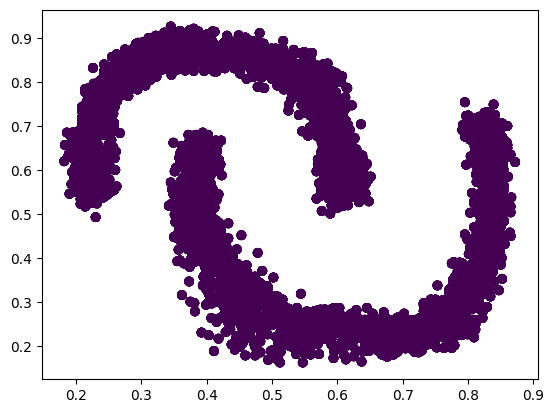

In [ ]:
for i in range(1,11):
    print('i=',i)
    DBSCAN_Model=DBSCAN(eps=0.3,min_samples=i).fit(df_test)
    print(DBSCAN_Model.labels_)
    plt.scatter(df_test.iloc[:,0],df_test.iloc[:,1],c=DBSCAN_Model.labels_)